In [ ]:
%load_ext nb_black
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data import make_dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    train_test_split,
    PredefinedSplit,
)
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer

# from category_encoders import OrdinalEncoder
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.inspection import permutation_importance
from rfpimp import *
from IPython.display import display, HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import shap  # package used to calculate Shap values
from tpot import TPOTRegressor

## NOTE
This notebook code has been written in a mostly procedural format.  This is so that I can demonstrate my thought process and decision making in a clear and logical way.  This code would need some re-factoring once I'm happy with my final solution, before thinking about getting it to a production ready format if required.

I have used 'Black' code reformatter to ensure the style is PEP 8 compliant.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    train_test_split,
    PredefinedSplit,
)
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer

# from category_encoders import OrdinalEncoder
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.inspection import permutation_importance
from rfpimp import *
from IPython.display import display, HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import shap  # package used to calculate Shap values
from tpot import TPOTRegressor

C:\Users\mshar\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
os.getcwd()

'C:\\Users\\mshar\\work\\store-sales-model\\notebooks'

<IPython.core.display.Javascript object>

## Feature Engineering
This step of the process is crucial for obtaining an accurate model.  It is also the most time consuming.  I've spent my time creating an end-to-end solution and therefore haven't dived as deeply into all of the necessary steps to produce the best model.  
Below I have listed most of the techniques I would normally try:
 - Imputation
- Drop records or columns with a high proportion of missing values
- Replace missing values with mean/median/mode (numeric) or mode (categorical)
 - One-hot Encoding
- Map categorical feature to N-1 binary columns
- Try to not create a sparse dataframe if feature contains many categories
 - Outliers
- Remove outliers entirely
- Capping the outliers using percentile cut-offs
- Binning the values
 - Simplify relationships to either binary flags or straight lines
 - Transformations
- Apply different transformations based on the shape of the distribution
- Square root, logarithm, inverse and reflect the distribution when it is negatively skewed
- Try to straighten the curve of a line to extract a stronger relationship
 - Mean Enconding for categorical features
- For categorical features, encode each level as the mean of the response
- Achieves many objectives including scaling, outliers, NULL values and interpretability
- Binning 
- For continuous features try quartiles, quintiles, deciles
 - Binning with Decision Trees
 - Polynomial Features, e.g. xsquared, xcubed 
 - Feature Interactions, e.g. x1x2
 - Derived Features using domain knowledge
 
NOTE: 
Random Forest is a tree-based model that uses a partitioning algorithm and does not require feature scaling.  The decision on where to split/partition the data will not change with scaling, i.e. the tree only sees ranks in the features.

In [5]:
# access store variables
%store -r df
%store -r predict

<IPython.core.display.Javascript object>

In [6]:
# we can do some of the pre-processing on the training and prediction data at the same time
df_combined = pd.concat([df, predict], axis=0, sort=False)
print(df_combined.shape)
df_combined.head(-5)

(333, 17)


,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county,data
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,All transport options,666,20.2,368.74,4.5325,-0.399933,c_40,train
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,Average transport options,264,13.0,388.37,1.8150,2.216308,c_80,train
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,Many transport options,307,17.4,378.35,2.9125,0.166920,c_53,train
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,No transport options,300,15.3,394.72,2.0575,-0.083804,c_65,train
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,Average transport options,256,15.1,392.90,0.9875,0.962693,c_97,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,227,1.517409,0.0,19.58,no,12.75,3.066,0.0,1.7573,Average transport options,403,14.7,353.89,1.6075,NaN,c_62,predict
4,114,83.093533,0.0,18.10,no,16.45,2.957,0.0,1.8026,All transport options,666,20.2,16.45,5.1550,NaN,c_22,predict
5,203,10.988323,0.0,18.10,no,19.50,3.406,2.8,2.0651,All transport options,666,20.2,385.96,4.8800,NaN,c_19,predict
6,12,0.159895,0.0,6.91,no,4.90,3.169,93.4,5.7209,No transport options,233,17.9,383.37,1.4525,NaN,c_63,predict


<IPython.core.display.Javascript object>

In [7]:
# convert object to category dtypes
df_combined["transport_availability"] = df_combined["transport_availability"].astype(
    "category"
)
df_combined["county"] = df_combined["county"].astype("category")

<IPython.core.display.Javascript object>

In [8]:
# map the ordinal values to integers
mapping_dict = {
    "transport_availability": {
        "All transport options": 5,
        "Many transport options": 4,
        "Average transport options": 3,
        "Few transport options": 2,
        "No transport options": 1,
    }
}
df_combined.replace(mapping_dict, inplace=True)
df_combined.head(5)

,location_id,crime_rate,proportion_flats,proportion_nonretail,new_store,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county,data
0,464,17.600541,0.0,18.10,no,NaN,2.926,29.0,2.9084,5,666,20.2,368.74,4.5325,-0.399933,c_40,train
1,504,0.603556,20.0,3.97,no,14.85,4.520,10.6,2.1398,3,264,13.0,388.37,1.8150,2.216308,c_80,train
2,295,0.606810,0.0,6.20,no,7.70,2.981,31.9,3.6715,4,307,17.4,378.35,2.9125,0.166920,c_53,train
3,187,0.012385,55.0,2.25,no,1.95,3.453,68.1,7.3073,1,300,15.3,394.72,2.0575,-0.083804,c_65,train
4,193,0.016182,100.0,1.32,no,3.05,3.816,59.5,8.3248,3,256,15.1,392.90,0.9875,0.962693,c_97,train


<IPython.core.display.Javascript object>

In [9]:
# one-hot encode new_store feature
df_combined = pd.get_dummies(df_combined, columns=["new_store"])

# check distribution of feature
print(df_combined["new_store_yes"].value_counts())

df_combined.head(5)

0    313
1     20
Name: new_store_yes, dtype: int64


,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county,data,new_store_no,new_store_yes
0,464,17.600541,0.0,18.10,NaN,2.926,29.0,2.9084,5,666,20.2,368.74,4.5325,-0.399933,c_40,train,1,0
1,504,0.603556,20.0,3.97,14.85,4.520,10.6,2.1398,3,264,13.0,388.37,1.8150,2.216308,c_80,train,1,0
2,295,0.606810,0.0,6.20,7.70,2.981,31.9,3.6715,4,307,17.4,378.35,2.9125,0.166920,c_53,train,1,0
3,187,0.012385,55.0,2.25,1.95,3.453,68.1,7.3073,1,300,15.3,394.72,2.0575,-0.083804,c_65,train,1,0
4,193,0.016182,100.0,1.32,3.05,3.816,59.5,8.3248,3,256,15.1,392.90,0.9875,0.962693,c_97,train,1,0


<IPython.core.display.Javascript object>

In [10]:
# encode county values with numeric labels
df_combined["county"] = df_combined["county"].cat.codes
df_combined.head(5)

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,school_proximity,competitor_density,household_affluency,normalised_sales,county,data,new_store_no,new_store_yes
0,464,17.600541,0.0,18.10,NaN,2.926,29.0,2.9084,5,666,20.2,368.74,4.5325,-0.399933,41,train,1,0
1,504,0.603556,20.0,3.97,14.85,4.520,10.6,2.1398,3,264,13.0,388.37,1.8150,2.216308,82,train,1,0
2,295,0.606810,0.0,6.20,7.70,2.981,31.9,3.6715,4,307,17.4,378.35,2.9125,0.166920,54,train,1,0
3,187,0.012385,55.0,2.25,1.95,3.453,68.1,7.3073,1,300,15.3,394.72,2.0575,-0.083804,66,train,1,0
4,193,0.016182,100.0,1.32,3.05,3.816,59.5,8.3248,3,256,15.1,392.90,0.9875,0.962693,97,train,1,0


<IPython.core.display.Javascript object>

In [11]:
# define list of features before further transformed features are added
# orig_features = df_combined.drop(columns=["normalised_sales", "data"]).columns
orig_features = df_combined.drop(columns=["normalised_sales", "data"]).columns
orig_features

Index(['location_id', 'crime_rate', 'proportion_flats', 'proportion_nonretail',
       'commercial_property', 'household_size', 'proportion_newbuilds',
       'public_transport_dist', 'transport_availability', 'property_value',
       'school_proximity', 'competitor_density', 'household_affluency',
       'county', 'new_store_no', 'new_store_yes'],
      dtype='object')

<IPython.core.display.Javascript object>

In [12]:
# apply transformations to some of the features

# apply log transformation adding one, to avoid negative values
df_combined["log_proportion_newbuilds"] = df_combined["proportion_newbuilds"].apply(
    np.log1p
)
df_combined["log_public_transport_dist"] = df_combined["public_transport_dist"].apply(
    np.log1p
)
# reflect the distribution first before applying log, since distribution is negatively skewed
df_combined["log_competitor_density"] = (
    (df_combined["competitor_density"].max() + 1) - df_combined["competitor_density"]
).apply(np.log1p)

# apply inverse transformation
df_combined["inv_commercial_property"] = df_combined["commercial_property"].apply(
    np.reciprocal
)
# reflect the distribution first before applying inverse, since distribution is negatively skewed
df_combined["inv_competitor_density"] = (
    (df_combined["competitor_density"].max() + 1) - df_combined["competitor_density"]
).apply(np.reciprocal)

<IPython.core.display.Javascript object>

## Splitting the Dataset
- We should re-use the parameters for the transformations applied to the training set for use on the test set to avoid information leakage
- Any predictions made should also use the same parameters
- If the dataset is sufficiently large we shouldn't expect to see much difference between the train and test parameters since we assume all samples have been drawn from the same distribution
- Information leakage can cause optimism bias in the model evaluation
- We should not use the response in the test set for anything except comparing to our predicted values

In [13]:
pd.options.mode.chained_assignment = None  # default='warn'

# split data for prediction
predict = df_combined.loc[df_combined["data"] == "predict"]
predict = predict.drop(columns=["normalised_sales", "data"])
print("Predict Features Shape:", predict.shape)

# use a seed value throughout notebook to ensure results are reproducible
seed = 42

# split the target value
X = df_combined.loc[df_combined["data"] == "train"].drop(
    columns=["normalised_sales", "data"]
)
y = df_combined.loc[df_combined["data"] == "train"]["normalised_sales"]

# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=seed
)

print("Training Features Shape:", X_train.shape)
print("Training Labels Shape:", y_train.shape)
print("Validation Features Shape:", X_test.shape)
print("Validation Labels Shape:", y_test.shape)

Predict Features Shape: (13, 21)
Training Features Shape: (240, 21)
Training Labels Shape: (240,)
Validation Features Shape: (80, 21)
Validation Labels Shape: (80,)


<IPython.core.display.Javascript object>

Scikit-learn estimators assume all values are numerical and that all have and hold meaning.  

More advanced techniques that could be tried include:
- To avoid discarding entire rows and/or columns containing missing values we can impute missing values.
- Multivariate Feature Imputation - 
 - Model each feature with missing values as a function of other features and use that estimate for imputation
 - It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. 
 - A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y.
- KNN Feature Imputation - 
 - A euclidean distance metric that supports missing values, nan_euclidean_distances, is used to find the nearest neighbors.
 - Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. 
 - The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. 
 - If a sample has more than one feature missing, then the neighbors for that sample can be different depending on the particular feature being imputed. 

In [14]:
def replace_missing_values(df):
    df["commercial_property"].fillna(
        (X_train["commercial_property"].median()), inplace=True
    )
    df["inv_commercial_property"].fillna(
        (X_train["inv_commercial_property"].median()), inplace=True
    )
    #     df["log_crime_rate"].fillna(
    #         (X_train["log_commercial_property"].median()), inplace=True
    #     )
    #     df["log_proportion_flats"].fillna(
    #         (X_train["log_proportion_flats"].median()), inplace=True
    #     )
    #     df["inv_crime_rate"].fillna(
    #         (X_train["inv_commercial_property"].median()), inplace=True
    #     )
    #     df["cap_commercial_property"].fillna(
    #         (X_train["cap_commercial_property"].median()), inplace=True
    #     )
    #     df["cap_proportion_flats"].fillna(
    #         (X_train["cap_proportion_flats"].median()), inplace=True
    #     )
    df["school_proximity"].fillna((X_train["school_proximity"].median()), inplace=True)
    return df


replace_missing_values(X_train)
replace_missing_values(X_test)
replace_missing_values(predict)

# check for missing values again
print("X_train missing values:", X_train.isnull().values.any())
print("X_test missing values:", X_test.isnull().values.any())
print("Predict missing values:", predict.isnull().values.any())

X_train missing values: False
X_test missing values: False
Predict missing values: False


<IPython.core.display.Javascript object>

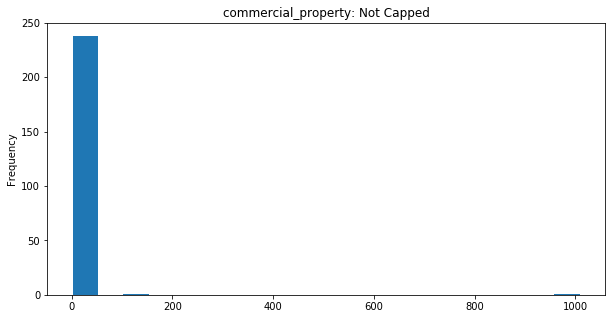

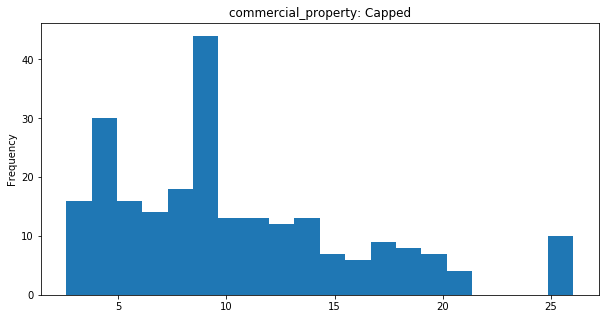

<IPython.core.display.Javascript object>

In [15]:
# create histogram showing distribution of commercial_property before capping outliers
hist1 = X_train["commercial_property"].plot(
    kind="hist", bins=20, figsize=(10, 5), title="commercial_property: Not Capped"
)
plt.show()

# cap outliers at the 1% and 99% percentile level
def cap_outliers(df, cap1, cap2):

    commercial_property_percentiles = (
        X_train["commercial_property"].quantile([cap1, cap2]).values
    )
    proportion_flats_percentiles = (
        X_train["proportion_flats"].quantile([cap1, cap2]).values
    )

    np.clip(
        df["commercial_property"],
        commercial_property_percentiles[0],
        commercial_property_percentiles[1],
        inplace=True,
    )
    np.clip(
        df["proportion_flats"],
        proportion_flats_percentiles[0],
        proportion_flats_percentiles[1],
        inplace=True,
    )

    # df['capped_commercial_property'] = np.clip(df['commercial_property'], commercial_property_percentiles[0], commercial_property_percentiles[1])
    # df['capped_proportion_flats'] = np.clip(df['proportion_flats'], proportion_flats_percentiles[0], proportion_flats_percentiles[1])

    return df


cap_outliers(X_train, 0.01, 0.99)
cap_outliers(X_test, 0.01, 0.99)
cap_outliers(predict, 0.01, 0.99)

# create histogram showing distribution of commercial_property after capping outliers
hist2 = X_train["commercial_property"].plot(
    kind="hist", bins=20, figsize=(10, 5), title="commercial_property: Capped"
)
plt.show()

In [16]:
# define labels for bins
labels = ["low", "high"]

# bin using quartile cut-off to ensure even split of samples
X_train["binned_commercial_property"], bins_commercial_property = pd.qcut(
    X_train["commercial_property"], q=2, retbins=True, labels=labels
)
# bin using cut since distribution of this feature is so imbalanced
X_train["binned_proportion_flats"], bins_proportion_flats = pd.cut(
    X_train["proportion_flats"], 2, retbins=True, labels=labels
)

# apply bin cut-offs from training data to test set
X_test["binned_commercial_property"] = pd.cut(
    X_test["commercial_property"], bins=bins_commercial_property, labels=labels
)
X_test["binned_proportion_flats"] = pd.cut(
    X_test["proportion_flats"], bins=bins_proportion_flats, labels=labels
)

# apply bin cut-offs from training data to predict set
predict["binned_commercial_property"] = pd.cut(
    predict["commercial_property"], bins=bins_commercial_property, labels=labels
)
predict["binned_proportion_flats"] = pd.cut(
    predict["proportion_flats"], bins=bins_proportion_flats, labels=labels
)

# one-hot encode new binned features
X_train = pd.get_dummies(
    X_train, columns=["binned_commercial_property", "binned_proportion_flats"]
)
X_test = pd.get_dummies(
    X_test, columns=["binned_commercial_property", "binned_proportion_flats"]
)
predict = pd.get_dummies(
    predict, columns=["binned_commercial_property", "binned_proportion_flats"]
)

X_train.head(5)

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,transport_availability,property_value,...,new_store_yes,log_proportion_newbuilds,log_public_transport_dist,log_competitor_density,inv_commercial_property,inv_competitor_density,binned_commercial_property_low,binned_commercial_property_high,binned_proportion_flats_low,binned_proportion_flats_high
93,32,0.040126,25.0,4.86,3.80,3.167,53.3,5.4007,2,281,...,0,3.994524,1.856407,2.111425,0.263158,0.137741,1,0,1,0
137,72,0.220791,0.0,10.81,3.15,3.245,93.8,5.2873,2,305,...,0,4.551769,1.838532,3.078694,0.317460,0.048239,1,0,1,0
59,138,0.023221,85.0,0.74,9.40,3.383,64.3,9.1876,1,313,...,0,4.178992,2.321171,0.693147,0.106383,1.000000,1,0,0,1
116,318,1.348022,0.0,21.89,13.70,3.326,2.3,2.2710,2,437,...,0,1.193922,1.185096,0.693147,0.072993,1.000000,0,1,1,0
6,43,0.254126,12.5,7.87,8.70,3.377,5.7,6.3467,3,311,...,0,1.902108,1.994251,1.853168,0.114943,0.185874,1,0,1,0


<IPython.core.display.Javascript object>

# Pipelines
To simplify the process of applying transformations it's best to use a pipeline. They have several key benefits:
 - They make the workflow much easier to read and understand.
 - They enforce the implementation and order of steps in the project.
 - These in turn make the work much more reproducible.
 
If we receive further prediction data in future or this model needs to be put into production then it's much more desirable to simply pass the data through a pipeline.

NOTE - Due to time constraints I haven't fully constructed a pipeline with all of the necessary components.

In [22]:
# this implementation of OrdinalEncoder is required to allow for unknown categories in unseen data
# the handle_categories option has not been rleased in sklearn yet
# Do not use from sklearn.preprocessing import _BaseEncoder, it is protected class!
from sklearn.preprocessing._encoders import _BaseEncoder


class new_OrdinalEncoder(_BaseEncoder):
    def __init__(self, cat_index="all"):
        self.dicts = {}
        # cate_index is the categorical feature index list
        self.cat_index = cat_index

    def fit(self, df, *y):
        if self.cat_index == "all":
            self.cat_index = list(range(df.shape[1]))
        for feat in self.cat_index:
            dic = np.unique(df.iloc[:, feat])
            dic = dict([(i, index) for index, i in enumerate(dic)])
            self.dicts[feat] = dic

    def fit_transform(self, df, *y):
        if self.cat_index == "all":
            self.cat_index = list(range(df.shape[1]))
        df_output = df.copy()
        for feat in self.cat_index:
            dic = np.unique(df.iloc[:, feat])
            dic = dict([(i, index) for index, i in enumerate(dic)])
            self.dicts[feat] = dic
            df_output.iloc[:, feat] = df.iloc[:, feat].apply(lambda x: dic[x])
        return df_output

    def transform(self, df):
        df_output = df.copy()
        for feat in self.cat_index:
            dic = self.dicts[feat]
            df_output.iloc[:, feat] = df.iloc[:, feat].apply(
                self.unknown_value, args=(dic,)
            )
        return df_output

    def unknown_value(
        self, value, dic
    ):  # It will set up a new interger for unknown values!
        try:
            return dic[value]
        except:
            return len(dic)

OrdinalEncoder
 - If a new value that never appears in the fit step needs to be converted in the transform step, OrdinalEncoder will raise an error. 
 - Such unknown value will cause a problem when the testing set contains an unknown value of the training set. 
 - In order to avoid unknown value in the testing set, we have to fit the entire data set for the OrdinalEncoder, which means we need to fit the OrdinalEncoder before splitting the dataset into training and testing. 
 - Even if we can fix unknown value in this way, it still does not work when new samples with unknown value fed into the model.
 - Due to the above I have used a custom implementation of OrdinalEncoder that handles missing values.

In [23]:
# df = train.copy()

# define the ordering for the categories used in the mapping of the ordinal feature
categories = [
    "All transport options",
    "Many transport options",
    "Average transport options",
    "Few transport options",
    "No transport options",
]

# replace missing values with median
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# apply logarithm transform
log_transformer = Pipeline(steps=[("log", FunctionTransformer(np.log1p))])

# apply inverse transform
inv_transformer = Pipeline(steps=[("inv", FunctionTransformer(np.reciprocal))])

# one-hot encode categorical feature
# if an unknown category is encountered during transform, the resulting ohe columns for this feature will all be zeros
categorical_transformer1 = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

# transform categorical feature to numeric with ordinal mapping
categorical_transformer2 = Pipeline(
    steps=[("ordinal1", OrdinalEncoder(categories=[categories]))]
)

# transform categorical feature to numeric with lexical (default method) ordering
# use a different implementation of OrdinalEncoder above to allow for unknown categories not seen in training data
categorical_transformer3 = Pipeline(steps=[("ordinal2", new_OrdinalEncoder())])

numeric_features = (
    train.drop(columns=["normalised_sales"])
    .select_dtypes(include=["int64", "float64"])
    .columns
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
        #        ,
        #        ('log', log_transformer, ['proportion_newbuilds','public_transport_dist'])
        ,
        #        ('inv', inv_transformer, ['commercial_property'])
        #        ,
        ("cat1", categorical_transformer1, ["new_store"]),
        ("cat2", categorical_transformer2, ["transport_availability"]),
        ("cat3", categorical_transformer3, ["county"]),
    ]
)

In [24]:
# check that transformations are being applied correctly
def get_feature_out(estimator, feature_in):
    if hasattr(estimator, "get_feature_names"):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f"vec_{f}" for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name != "remainder":
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator == "passthrough":
            output_features.extend(ct._feature_names_in[features])

    return output_features


transformed_data = preprocessor.fit_transform(train)

pd.DataFrame(transformed_data, columns=get_ct_feature_names(preprocessor))

,location_id,crime_rate,proportion_flats,proportion_nonretail,commercial_property,household_size,proportion_newbuilds,public_transport_dist,property_value,school_proximity,competitor_density,household_affluency,new_store_no,new_store_yes,transport_availability,county
0,464.0,17.600541,0.0,18.10,9.40,2.926,29.0,2.9084,666.0,20.2,368.74,4.5325,1.0,0.0,0.0,39.0
1,504.0,0.603556,20.0,3.97,14.85,4.520,10.6,2.1398,264.0,13.0,388.37,1.8150,1.0,0.0,2.0,80.0
2,295.0,0.606810,0.0,6.20,7.70,2.981,31.9,3.6715,307.0,17.4,378.35,2.9125,1.0,0.0,1.0,52.0
3,187.0,0.012385,55.0,2.25,1.95,3.453,68.1,7.3073,300.0,15.3,394.72,2.0575,1.0,0.0,4.0,64.0
4,193.0,0.016182,100.0,1.32,3.05,3.816,59.5,8.3248,256.0,15.1,392.90,0.9875,1.0,0.0,2.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,106.0,0.102468,45.0,3.44,9.40,3.951,78.5,6.4798,398.0,15.2,377.68,1.2750,1.0,0.0,2.0,67.0
316,24.0,0.621579,20.0,3.97,14.85,4.206,8.4,1.9301,264.0,13.0,387.89,2.0250,1.0,0.0,2.0,97.0
317,473.0,0.907062,0.0,8.14,9.40,2.456,63.4,3.7965,307.0,21.0,288.99,2.9225,1.0,0.0,3.0,35.0
318,76.0,0.105079,0.0,25.65,11.55,2.961,7.1,2.0869,188.0,19.1,378.09,4.4825,1.0,0.0,4.0,68.0
